--- Tải Dữ liệu đã có Feature ---
--- Tải Dữ liệu đã có Feature ---
Kích thước Ma trận X (Feature): (48895, 9)
Kích thước Vector Y (Target 5 mức): (48895,)

Train set: 39116 samples
Test set: 9779 samples

--- Bắt đầu huấn luyện Logistic Regression OvR (NumPy) ---
Hyperparameters: LR=0.01, Iterations=8000
Bắt đầu Huấn luyện 5 Mô hình (One-vs-Rest)...

--- Huấn luyện Mô hình cho Lớp 1 vs Phần còn lại ---
  > Iteration 0/8000, Loss: 0.6919
  > Iteration 800/8000, Loss: 0.3908
  > Iteration 1600/8000, Loss: 0.3313
  > Iteration 2400/8000, Loss: 0.2986
  > Iteration 3200/8000, Loss: 0.2764
  > Iteration 4000/8000, Loss: 0.2599
  > Iteration 4800/8000, Loss: 0.2469
  > Iteration 5600/8000, Loss: 0.2362
  > Iteration 6400/8000, Loss: 0.2273
  > Iteration 7200/8000, Loss: 0.2196

--- Huấn luyện Mô hình cho Lớp 2 vs Phần còn lại ---
  > Iteration 0/8000, Loss: 0.6921
  > Iteration 800/8000, Loss: 0.4613
  > Iteration 1600/8000, Loss: 0.4364
  > Iteration 2400/8000, Loss: 0.4267
  > Iteration 3

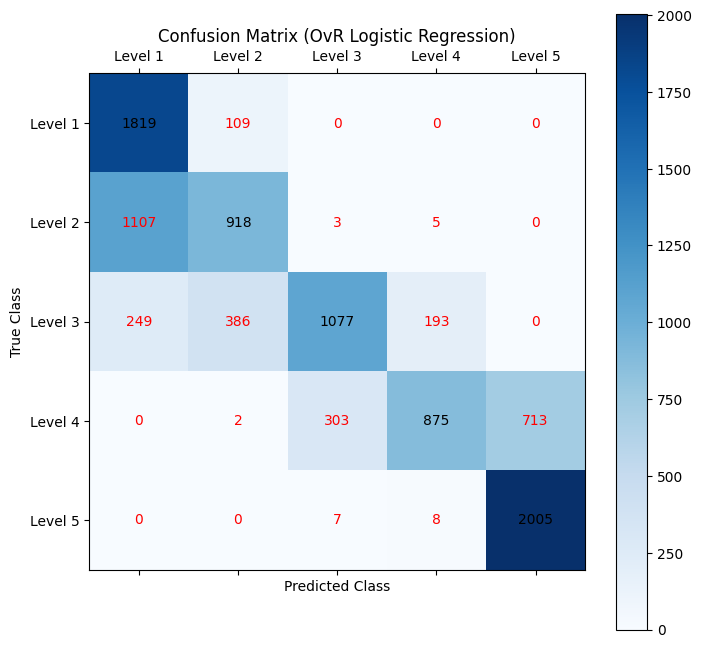

In [5]:
## 03_modeling.ipynb

# ==========================================================
# 1. THIẾT LẬP VÀ LOAD DỮ LIỆU
# ==========================================================

import sys, os
import numpy as np

# Thiết lập đường dẫn và Import các hàm cần thiết
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_processing import load_airbnb, convert_columns 
from src.models import (
    train_ovr_logistic_regression, 
    predict_ovr, 
    calculate_accuracy, compute_confusion_matrix, plot_confusion_matrix
    # sigmoid (cần cho việc phân tích trọng số)
) 

# --- 1. Tải Dữ liệu đã có Feature ---
print("--- Tải Dữ liệu đã có Feature ---")
header, rows = load_airbnb(filename="AB_NYC_2019_featured.csv", source_dir="processed")

print("--- Tải Dữ liệu đã có Feature ---")

# CHỈ CẦN THÊM TẤT CẢ CÁC CỘT Z-SCORE VÀO DANH SÁCH NÀY
cols_to_use = [
    'grid_demand_zscore', 
    'grid_price_efficiency_zscore', 
    'grid_activity_density_zscore', 
    'target_market_strength_level', # Target 5 mức
    # THÊM CÁC CỘT Z-SCORE MỚI:
    'price_zscore', 
    'minimum_nights_zscore', 
    'reviews_per_month_zscore',
    'calculated_host_listings_count_zscore',
    'availability_365_zscore' 
]
# Hà
cols_dict = convert_columns(rows, header, numeric_cols=cols_to_use)

# ==========================================================
# 2. CHUẨN BỊ MA TRẬN X VÀ Y (OVR)
# ==========================================================

# --- 2.1. Lọc Dữ liệu và Target 5 mức ---
target_levels = cols_dict['target_market_strength_level']['values']
# Valid mask: Loại bỏ các hàng có Target là NaN (nếu có)
valid_mask = ~np.isnan(target_levels) 

# Target Đa Lớp (Y_multi)
Y_multi = target_levels[valid_mask] 
'/.;'
# --- 2.2. Xây dựng Ma trận Feature (X) ---
# Thêm các Feature Z-score gốc vào danh sách
feature_cols = [
    'grid_demand_zscore', 
    'grid_price_efficiency_zscore', 
    'grid_activity_density_zscore',
    # THÊM CÁC FEATURE Z-SCORE GỐC:
    'price_zscore', 
    'minimum_nights_zscore', 
    'reviews_per_month_zscore',
    'calculated_host_listings_count_zscore',
    'availability_365_zscore'
]

# Lọc dữ liệu Feature chỉ lấy các hàng hợp lệ theo Target mask
X_features = [cols_dict[col]['values'][valid_mask] for col in feature_cols]

# Thêm cột Bias (Intercept)
X_bias = np.ones((len(X_features[0]), 1))

# Ghép tất cả các cột lại thành Ma trận X (NumPy)
X = np.column_stack([X_bias] + X_features)

print(f"Kích thước Ma trận X (Feature): {X.shape}") # (N, 9)
print(f"Kích thước Vector Y (Target 5 mức): {Y_multi.shape}")

# ==========================================================
# 3. CHIA DỮ LIỆU VÀ HUẤN LUYỆN MÔ HÌNH (OVR)
# ==========================================================

# --- 3.1. Chia Train/Test ---
TEST_SIZE = 0.2
SEED = 42
np.random.seed(SEED)

indices = np.arange(X.shape[0])
np.random.shuffle(indices)

test_count = int(X.shape[0] * TEST_SIZE)
test_indices = indices[:test_count]
train_indices = indices[test_count:]

X_train = X[train_indices]
Y_train_multi = Y_multi[train_indices]
X_test = X[test_indices]
Y_test_multi = Y_multi[test_indices]

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# --- 3.2. Huấn luyện (Training) OvR ---
LEARNING_RATE = 0.01
NUM_ITERATIONS = 8000

print(f"\n--- Bắt đầu huấn luyện Logistic Regression OvR (NumPy) ---")
print(f"Hyperparameters: LR={LEARNING_RATE}, Iterations={NUM_ITERATIONS}")

# Hàm train_ovr_logistic_regression sẽ trả về Ma trận Trọng số (5 x 4)
W_ovr = train_ovr_logistic_regression(
    X_train, 
    Y_train_multi, 
    NUM_ITERATIONS, 
    LEARNING_RATE
)

print("\n--- Ma trận Trọng số (W_ovr) đã tối ưu (5x4) ---")
print(W_ovr)

# ==========================================================
# 4. ĐÁNH GIÁ VÀ PHÂN TÍCH KẾT QUẢ
# ==========================================================

# --- 4.1. Dự đoán và Tính Accuracy ---
Y_pred_ovr = predict_ovr(X_test, W_ovr)

# Tính Accuracy
accuracy_ovr = calculate_accuracy(Y_test_multi, Y_pred_ovr)

print(f"\n--- Kết quả Đánh giá trên Tập Test (OvR) ---")
print(f"Overall Accuracy: {accuracy_ovr:.4f}")

# --- 4.2. Phân tích Trọng số (W) ---
feature_labels = ['Intercept (Bias)'] + feature_cols
class_labels = [f'Level {i}' for i in range(1, 6)]

print("\n--- Phân tích Trọng số (W) cho từng Lớp (Level 1-5) ---")

# In Header
header_line = "{:<12}".format("")
for label in feature_labels:
    header_line += "{:>12}".format(label)
print(header_line)
print("-" * 92)

# In từng hàng (Level)
for i, level_label in enumerate(class_labels):
    row_line = "{:<12}".format(level_label)
    for j in range(W_ovr.shape[1]):
        row_line += "{:>12.6f}".format(W_ovr[i, j])
    print(row_line)
## 03_modeling.ipynb (Cell 6: Đánh giá)

# ... (Phần tính Accuracy) ...

# --- 4.3. Phân tích Chi tiết Lỗi (Confusion Matrix) ---
class_labels = [f'Level {i}' for i in range(1, 6)]
cm = compute_confusion_matrix(Y_test_multi, Y_pred_ovr, num_classes=5)

print("\n--- Confusion Matrix (Ma trận Lỗi 5x5) ---")

# Tạo Header cho CM
cm_header = "{:<10}".format("True \\ Pred")
for label in class_labels:
    cm_header += "{:>10}".format(label)
print(cm_header)
print("-" * 60)

# In từng hàng của Ma trận (True Class)
for i, true_label in enumerate(class_labels):
    row_line = "{:<10}".format(true_label)
    for j in range(cm.shape[1]):
        row_line += "{:>10}".format(cm[i, j])
    print(row_line)

# Tự động vẽ Confusion Matrix (Hàm plot_confusion_matrix)
plot_confusion_matrix(cm, class_labels)
